<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Convolutional Neural Network (CNN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.13.1].
device:[cuda:0].


### Dataset

In [2]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


### Data Iterator

In [3]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


### Define Model

In [4]:
class ConvolutionalNeuralNetworkClass(nn.Module):
    def __init__(self,name='cnn',xdim=[1,28,28],ksize=3,cdims=[32,64],hdims=[1024,128],ydim=10,USE_BATCHNORM=False):
      # 이미지의 개수 1, 28x28
        super(ConvolutionalNeuralNetworkClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.ksize = ksize
        self.cdims = cdims
        self.hdims = hdims
        self.ydim = ydim
        self.USE_BATCHNORM = USE_BATCHNORM

        # Convolutional layers
        self.layers = []
        prev_cdim = self.xdim[0] # input의 dimension
        ## 이미지의 개수 1
        
        for cdim in self.cdims: # for each hidden layer
          # [32,64]
            self.layers.append(
                nn.Conv2d(
                  in_channels=prev_cdim, # 커널의 차원
                  out_channels=cdim,
                  ## 이미지의 개수 = 커널의 차원
                    ## 커널의 개수 = feature map의 차원이므로,
                    ## 1 -> 32, 하나의 이미지가 들어왔으므로, 하나의 커널이 32개가 있으며 feature map의 개수는 곧 32개가 된다
                    ## 32 -> 64, 32개의 feature map (이미지와 동일한 입장)이 들어왔으므로, 32차원의 커널이 64개 있으며 이는 곧 64개의 feature map이 된다
                  kernel_size=self.ksize, # 커널의 차원, 숫자가 두 개일 경우, 차원의 원소 두 개를 달리 한다는 것
                  stride=(1,1), 
                  padding=self.ksize//2
                  ## input과 output 사이즈가 동일하도록
                )) # convlution 
            if self.USE_BATCHNORM:
                self.layers.append(nn.BatchNorm2d(cdim)) # batch-norm ## BatchNorm2d(num of features)
            self.layers.append(nn.ReLU(True))  # activation
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) # max-pooling 
            # 해당 max pooling을 지나가면 반씩 줄도록
            # max pooling: 커널 사이즈 2x2에서 가장 큰 값만 뽑아내게 된다
              ## 28x28 -3x3-> 28x28 -max pooling-> 14x14 -3x3-> 14x14 -max pooling-> 7x7
            self.layers.append(nn.Dropout2d(p=0.5))  # dropout
              ## dropout은 train phase와 inference phase에서 다르게 동작함 !
              ## 이와 같이
            prev_cdim = cdim

        # Dense layers
        self.layers.append(nn.Flatten()) # 가장 마지막 레이어를 한 줄로 폈을 때
        prev_hdim = prev_cdim*(self.xdim[1]//(2**len(self.cdims)))*(self.xdim[2]//(2**len(self.cdims)))
        # 몇 개의 노드 개수가 될지 계산
          ## self.xdim[1] : 28, self.xdim[2] : 28
          ## len(cdims)이 곧 convolution 계산 (노드)의 개수가 되므로, 
          ## max pooling인 제곱하여 이미지 차원이 줄어든 만큼 나누어 준다
            ## 만약 max pooling이 3으로 나누어지는 것이라면, kernel_size=(3,3), stride=(3,3) 2**가 아닌 3**으로 해준다
          ## 28//(2*2) = 7x7
        for hdim in self.hdims: # [1024,128]
            self.layers.append(nn.Linear(
              prev_hdim, hdim, bias=True
                               ))
            # 49 (7x7) -> 1024
              ## 마지막 개수: prev_hdim
              ## 1024 -> 128
            self.layers.append(nn.ReLU(True))  # activation
            prev_hdim = hdim
            
        # Final layer (without activation)
        self.layers.append(nn.Linear(prev_hdim,self.ydim,bias=True))
          # 128 -> 10
            ## 마지막 분류 개수에 따라 마지막 레이어 노드 개수

        # Concatenate all layers 
          ## Sequential(): 여러 layer을 묶어주는 함수
        self.net = nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.net.add_module(layer_name,layer) # add_module 메서드를 통해 Sequential 안에 넣어주는 것
            
        self.init_param() # initialize parameters
        
    def init_param(self):
        for m in self.modules(): # modules(): 신경망이 가진 module들을 iterator로 반환
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight) # nn.init.kaiming_normal_
                nn.init.zeros_(m.bias) # nn.init.zeros_: 0으로 설정
            elif isinstance(m,nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0) # nn.init.constant_: 상수로 설정
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            
    def forward(self,x):
        return self.net(x)

C = ConvolutionalNeuralNetworkClass(hdims=[32]).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(C.parameters(), lr=1e-3)
print("Done.")

Done.


### Check Parameters

In [5]:
np.set_printoptions(precision=3) # set_printoptions: 반올림 함수, precision: 반올림 위치
  ## numpy의 출력 옵션을 변환해주는 것
n_param = 0

for p_idx, (param_name, param) in enumerate(C.named_parameters()):
  # .named_parameters() : (name, parameter) 조합의 tuple iterator를 반환
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        ## detach() : 파이토치는 모든 연산을 추적해서 기록해놓게 되는제, detach()를 사용하면 해당 연산 기록으로부터 분리한 tensor을 반환하게 된다
        n_param += len(param_numpy.reshape(-1)) # = x.reshape(1, -1) : 1차원의 배열을 반환한 것의 length
        print ("[%d] name:[%s] shape:[%s]."%(p_idx, param_name, param_numpy.shape)) # 각 파라미터의 이름과 shape
        print ("    val:%s"%(param_numpy.reshape(-1)[:5])) # 값 출력
print ("Total number of parameters:[%s]."%(format(n_param,',d'))) # 총 파라미터 개수

[0] name:[net.conv2d_00.weight] shape:[(32, 1, 3, 3)].
    val:[ 0.383 -0.12  -0.508 -0.896  0.222]
[1] name:[net.conv2d_00.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[net.conv2d_04.weight] shape:[(64, 32, 3, 3)].
    val:[ 0.134 -0.011 -0.094 -0.151 -0.083]
[3] name:[net.conv2d_04.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[4] name:[net.linear_09.weight] shape:[(32, 3136)].
    val:[ 0.003 -0.035 -0.002  0.014  0.017]
[5] name:[net.linear_09.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[6] name:[net.linear_11.weight] shape:[(10, 32)].
    val:[-0.065  0.357  0.31  -0.024 -0.564]
[7] name:[net.linear_11.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[119,530].


convolution + pooling 두 번을 거치고, 두 개의 linear를 거친 파라미터 값을 모두 보여줌
- hdims=[32]으로 넣은 하나의 linear와 + 마지막 분류 (10개) linear layer

### Simple Forward Path of the CNN Model

In [6]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)

x_numpy = np.random.rand(2,1,28,28)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = C.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array

print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("\nx_numpy %s:\n"%(x_numpy.shape,),x_numpy)
print ("y_numpy %s:\n"%(y_numpy.shape,),y_numpy)

x_torch:
 tensor([[[[0.423, 0.226, 0.582,  ..., 0.629, 0.774, 0.213],
          [0.033, 0.170, 0.442,  ..., 0.627, 0.384, 0.372],
          [0.460, 0.667, 0.985,  ..., 0.602, 0.831, 0.307],
          ...,
          [0.335, 0.812, 0.524,  ..., 0.855, 0.009, 0.876],
          [0.969, 0.120, 0.254,  ..., 0.111, 0.590, 0.299],
          [0.780, 0.259, 0.851,  ..., 0.606, 0.981, 0.701]]],


        [[[1.000, 0.431, 0.805,  ..., 0.332, 0.035, 0.742],
          [0.572, 0.267, 0.035,  ..., 0.658, 0.956, 0.751],
          [0.775, 0.079, 0.404,  ..., 0.814, 0.964, 0.529],
          ...,
          [0.773, 0.149, 0.644,  ..., 0.023, 0.564, 0.245],
          [0.336, 0.303, 0.648,  ..., 0.590, 0.456, 0.870],
          [0.226, 0.278, 0.112,  ..., 0.393, 0.482, 0.836]]]], device='cuda:0')
y_torch:
 tensor([[ 1.856,  0.992,  0.802,  2.607,  0.897, -0.358, -1.031, -2.090, -0.296,
          0.755],
        [ 1.694, -2.978,  4.366,  1.370,  3.016,  2.198,  4.457, -0.648,  1.257,
          2.668]], device=

### Evaluation Function

In [16]:
def func_eval(model, data_iter, device):
    with torch.no_grad(): # test 시점에서 no_grad()을 사용하면서 backward pass로 인해 쌓이는 메모리를 방지
        n_total, n_correct = 0, 0
        model.eval() # evaluate (affects DropOut and BN)
        ## eval(): nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수
        ## = evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
          ## DropOut과 BN의 경우, evaluation 과정에서 사용하지 않아야 하는 layer들 ??
            ### DropOut: 오버피팅을 방지하기 위해 노드를 제거하는 것 -> 학습 때 오버피팅 방지
            ### BN: batch_size를 가지고 평균과 분산을 계산하게 되는데, 동일한 데이터가 test로 들어온다한들 함께 들어오는 데이터가 하나라도 변환되게 될 경우, 평균과 분산이 달라지게 되면서 모델이 다른 결과를 낼 수 있기 때문
              #### evaluation 때, 각각의 Batch에서 계산했던 (평균과 분산들)의 평균을 가지고 자징헤 들어오는 데이터의 분포와 상관없이 고정된 값으로, 정규화를 진행하게 된다
        
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device) # 실제 정답
            model_pred = model(batch_in.view(-1,1,28,28).to(device))
            _, y_pred = torch.max(model_pred.data, 1)
            ## (배치 크기)x(클래스의 개수)이므로 배치 크기에 따라 각 클래스가 정답일 확률을 지니게 된다
            ## 따라서 행(0), 열(1) 중 열을 기준으로 최댓값을 뽑아 예측값을 하나 만드는 것
              ### outputs = [[0.1, 0.4, 0.5], [0.2, 0.6, 0,2]] 일 경우, 첫 번째의 이미지의 경우 2번째 클래스 (0.5)가 정답으로 유추한 값이며 두 번째 이미지의 경우 1번째 클래스 (0.6)가 정답이라고 예측한 것일 것
              ### 이처럼 열을 기준으로 최대값을 뽑아 torch.max는 최댓값과 최댓값의 위치를 산출해주게 되는데 여기서 최댓값보다는 최댓값의 위치 (클래스)를 알고자 하므로 _, y_pred 와 같이 두 번째 값만 받는 것
            ## .data는 예측값을 계산할 때는 역전파 계산이 필요없기 때문에 데이터만 사용한다는 의미
              ### with torch.no_grad() 사용해서 .data가 없어도 될 것 같다
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


### Initial Evaluation

In [19]:
C.init_param() # initialize parameters
train_accr = func_eval(C,train_iter,device)
test_accr = func_eval(C,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.039] test_accr:[0.037].


### Train

In [20]:
print ("Start training.")
C.init_param() # initialize parameters
C.train() # to train mode 
## .eval()과 동일하게 train mode에서 사용되어야 하는 dropout, BN을 켜주게 된다
EPOCHS,print_every = 10,1

for epoch in range(EPOCHS):
    loss_val_sum = 0
    
    for batch_in, batch_out in train_iter:
      
        # Forward path
        y_pred = C.forward(batch_in.view(-1,1,28,28).to(device))
        loss_out = loss(y_pred, batch_out.to(device))
        
        # Update
        optm.zero_grad() # reset gradient
        loss_out.backward() # backpropagate
        optm.step() # optimizer update
        
        loss_val_sum += loss_out
        
    loss_val_avg = loss_val_sum/len(train_iter)
    

    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(C, train_iter, device)
        test_accr = func_eval(C, test_iter, device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")

Start training.
epoch:[0] loss:[0.600] train_accr:[0.955] test_accr:[0.956].
epoch:[1] loss:[0.185] train_accr:[0.973] test_accr:[0.974].
epoch:[2] loss:[0.134] train_accr:[0.978] test_accr:[0.978].
epoch:[3] loss:[0.110] train_accr:[0.983] test_accr:[0.984].
epoch:[4] loss:[0.094] train_accr:[0.984] test_accr:[0.983].
epoch:[5] loss:[0.086] train_accr:[0.986] test_accr:[0.985].
epoch:[6] loss:[0.078] train_accr:[0.988] test_accr:[0.987].
epoch:[7] loss:[0.070] train_accr:[0.989] test_accr:[0.986].
epoch:[8] loss:[0.065] train_accr:[0.990] test_accr:[0.988].
epoch:[9] loss:[0.062] train_accr:[0.991] test_accr:[0.988].
Done


### Test

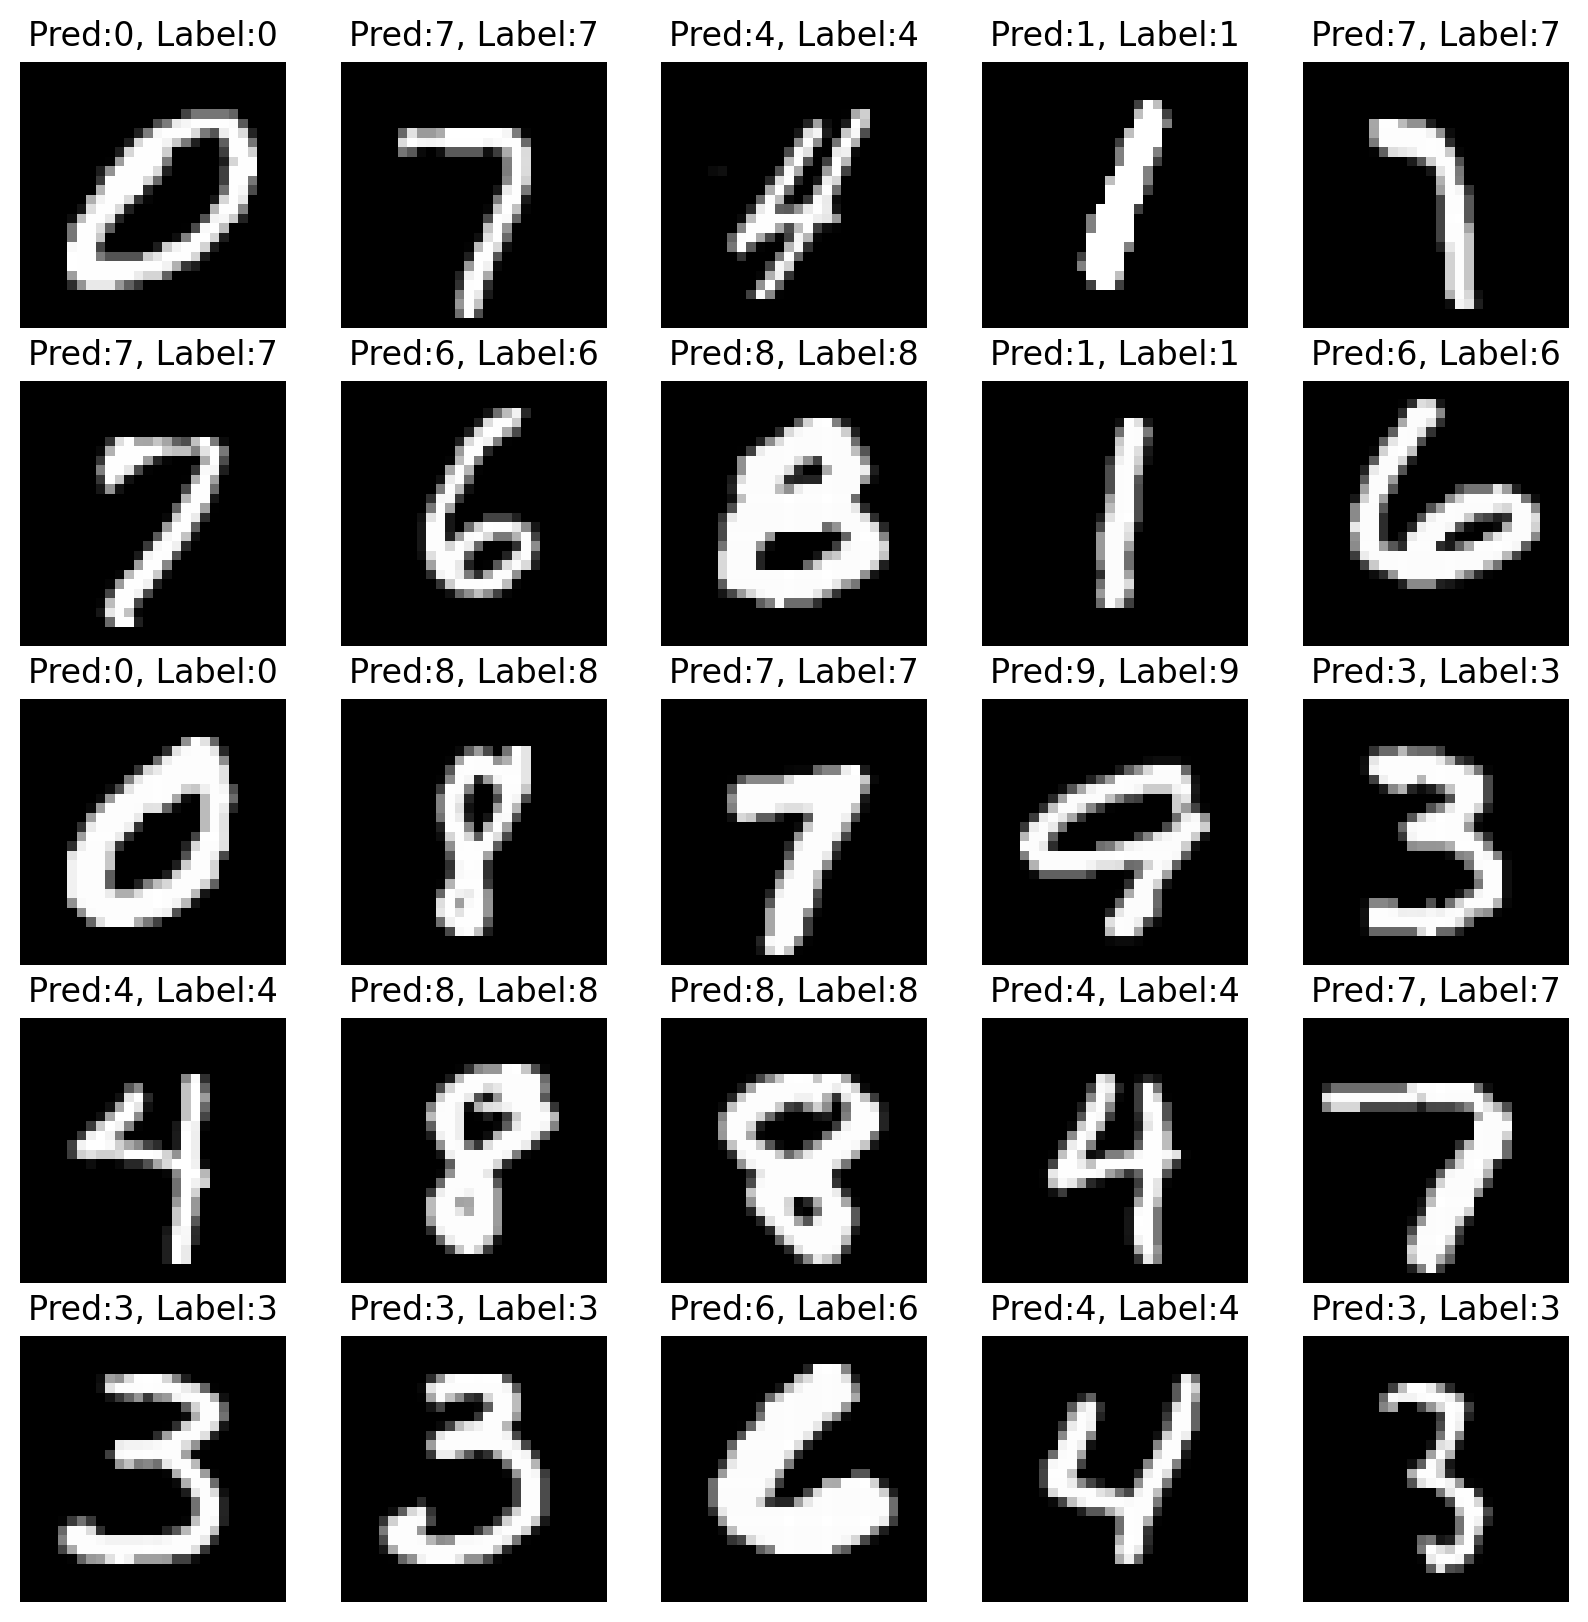

Done


In [21]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]

with torch.no_grad():
    C.eval() # to evaluation mode 
    y_pred = C.forward(test_x.view(-1,1,28,28).type(torch.float).to(device)/255.)
    
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))

for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

